# ***Introduction to Radar Using Python and MATLAB***
## Andy Harrison - Copyright (C) 2019 Artech House
<br/>

# Stripmap SAR (2D)
***

Stripmap SAR uses the same backprojection algorithm as does spotlight mode SAR.  The backprojection imaging process is as follows;

1. Construct the spatial domain target density array $f (x_i , y_j)$.
2. Pulse compress return signals and perform filtering.
3. Upsample the returns for better image quality. Upsample factors can be large $( > 100 )$.
4. For a given pixel point, $(x_i , y_j)$, find the nearest upsampled time point (interpolate) and add the value of the filtered data to the array component $f (x_i , y_j)$.
5. Repeat for all pixel locations $(x_i , y_j)$ and all pulses.

The filtered backprojection algorithm has several advantages.  It is computationally efficient and employs the fast Fourier transform (FFT).  It is highly parallelizable as each projection's contribution and each pixel's value may be computed separately.  Also, image reconstruction may begin as soon as the first projection function is obtained, rather than waiting for all projections to be collected.  Finally, the filtered backprojection algorithm does not depend on uniform angular sampling in the projection data, and multiple object rotations or platform passes can be used.
***

Begin by getting the library path

In [1]:
import lib_path

Set the squint angle

In [2]:
from numpy import radians

squint_angle = radians(0)

Set the **x** and **y** image center

In [3]:
from numpy import tan

x_center = 1000

y_center = x_center * tan(squint_angle)

Set the range to the center of the image (m), the **x** location of the target, they **y** location of the target, the target RCS (m^2)

In [4]:
range_center = 1e3

xt = [-3.0, 8.0]

yt = [10.0, -40.0]

rt = [5.0, 10.0]

Set image span in the **x** and **y** directions

In [5]:
x_span = 30.0

y_span = 100.0

Set the number of bins in the **x** and **y** directions

In [6]:
nx = 400

ny = 400

Set the aperture length (m) and the antenna width (m)

In [7]:
aperture_length = 100

antenna_width = 2.0

Set the start freuqency (Hz) and the bandwidth (Hz) of the transmitted signal

In [8]:
start_frequency = 1e9

bandwidth = 100e6

Set the window type (Rectangular, Hanning, or Hamming)

In [9]:
window_type = 'Hanning'

Set the dynamic range for the image (dB)

In [10]:
dynamic_range = 50

Set up the image space (m)

In [11]:
from numpy import linspace, meshgrid, zeros_like


xi = linspace(-0.5 * x_span + x_center, 0.5 * x_span + x_center, nx)

yi = linspace(-0.5 * y_span + y_center, 0.5 * y_span + y_center, ny)


x_image, y_image = meshgrid(xi, yi)

z_image = zeros_like(x_image)

Calculate the wavelength at the start frequency (m)

In [12]:
from scipy.constants import speed_of_light as c

wavelength = c / start_frequency

Calculate the number of frequencies

In [13]:
from numpy import sqrt, ceil

df = c / (2.0 * sqrt(x_span ** 2 + y_span ** 2))

number_of_frequencies = int(ceil(bandwidth / df))

Set up the frequency space

In [14]:
frequency = linspace(start_frequency, start_frequency + bandwidth, number_of_frequencies)

Set the length of the FFT

In [15]:
from scipy.fftpack import next_fast_len

fft_length = next_fast_len(4 * number_of_frequencies)

Calculate the element spacing (m)

In [16]:
element_spacing = wavelength / 4.0

Calculate the number of antenna elements

In [17]:
number_of_elements = int(ceil(antenna_width / element_spacing + 1))

Calculate the spacing on the synthetic aperture (m)

In [18]:
aperture_spacing = tan(c / (2 * y_span * start_frequency)) * x_center  # Based on y_span

Calculate the number of samples (pulses) on the aperture

In [19]:
number_of_samples = int(ceil(aperture_length / aperture_spacing + 1))

Create the aperture

In [20]:
synthetic_aperture = linspace(-0.5 * aperture_length, 0.5 * aperture_length, number_of_samples)

Calculate the sensor location

In [21]:
sensor_x = zeros_like(synthetic_aperture)

sensor_y = synthetic_aperture

sensor_z = zeros_like(synthetic_aperture)

Initialize the signal

In [22]:
from numpy import zeros

signal = zeros([number_of_frequencies, number_of_samples], dtype=complex)

Initialize the range center (m)

In [23]:
range_center = zeros_like(synthetic_aperture)

Phase term for the range phase (rad)

In [24]:
from scipy.constants import pi

phase_term = -1j * 4.0 * pi * frequency / c

Create the signal (k-space)

In [25]:
from numpy import arctan, cos, exp

from Libs.antenna.array.linear_array_un import array_factor


index = 0

for sa in synthetic_aperture:
    
    range_center[index] = sqrt(x_center ** 2 + (y_center - sa) ** 2)
    

    for x, y, r in zip(xt, yt, rt):
        
        # Antenna pattern at each target
        target_range = sqrt((x_center + x) ** 2 + (y_center + y - sa) ** 2) - range_center[index]
        
        target_azimuth = arctan((y_center + y - sa) / (x_center + x))
        
        antenna_pattern = array_factor(number_of_elements, 0.5 * pi - squint_angle, element_spacing,
                                               start_frequency, 0.5 * pi - target_azimuth, 'Uniform', 0) * cos(squint_angle)
        
        signal[:, index] += r * antenna_pattern ** 2 * exp(phase_term * target_range)
        
    index += 1

Get the selected window

In [26]:
from numpy import ones, outer

from scipy.signal.windows import hanning, hamming


if window_type == 'Hanning':
    
    h1 = hanning(number_of_frequencies, True)
    
    h2 = hanning(number_of_samples, True)
    
    coefficients = sqrt(outer(h1, h2))
    
elif window_type == 'Hamming':
    
    h1 = hamming(number_of_frequencies, True)
    
    h2 = hamming(number_of_samples, True)
    
    coefficients = sqrt(outer(h1, h2))
    
elif window_type == 'Rectangular':
    
    coefficients = ones([number_of_frequencies, number_of_samples])

Apply the selected window

In [27]:
signal *= coefficients

Reconstruct the image using the `backprojection` routines

In [28]:
from Libs.sar import backprojection

bp_image = backprojection.reconstruct(signal, sensor_x, sensor_y, sensor_z, range_center, x_image, y_image, z_image, frequency, fft_length)

Display the stripmap image using the `matplotlib` routines

(985.0, 1015.0, -50.0, 50.0)

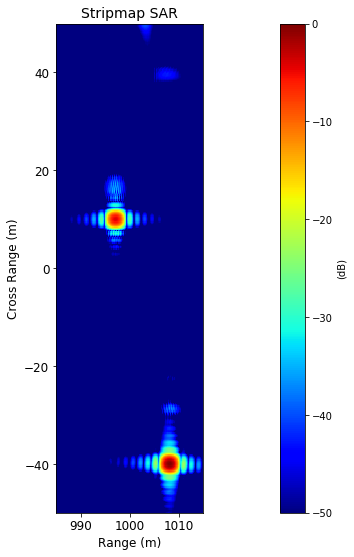

In [30]:
from matplotlib import pyplot as plt

from scipy import log10, amax


# Normalize the image

bpi = abs(bp_image) / amax(abs(bp_image))



# Set the figure size

plt.rcParams["figure.figsize"] = (6, 9)


# Set up the axes

fig, axes1 = plt.subplots()


# create the color plot

im = axes1.pcolor(xi, yi, 20.0 * log10(bpi), cmap='jet', vmin=-dynamic_range, vmax=0)

cbar = fig.colorbar(im, ax=axes1, orientation='vertical')

cbar.set_label("(dB)", size=10)



# Set the plot title and labels

axes1.set_title('Stripmap SAR', size=14)

axes1.set_xlabel('Range (m)', size=12)

axes1.set_ylabel('Cross Range (m)', size=12)



# Set the tick label size

axes1.tick_params(labelsize=12)


# Set the axis to be 'image'
axes1.axis('image')